# Réduction de dimension par concaténation des bandes

On souhaite diminuer la dimension des séries temporelles (à 4 bandes) pour qu'elles soient univariées pour chaque pixel.

In [70]:
from cookie_clusters import *

In [2]:
from sklearn.decomposition import PCA
import os
import itertools
from PIL import Image
import rasterio as rio
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastdtw as dtw

In [3]:
# List of target pixels
pixels_de_interet, dic_de_pixels = create_dic_pixels()
len(pixels_de_interet)
pixels_de_interet
dic_de_pixels

{'pix_foret': [[472, 570],
  [474, 570],
  [476, 570],
  [478, 570],
  [480, 570],
  [482, 570],
  [484, 570],
  [486, 570],
  [488, 570]],
 'pix_lac': [[392, 567],
  [392, 580],
  [401, 577],
  [401, 567],
  [395, 570],
  [395, 576],
  [397, 571],
  [394, 598],
  [388, 532]],
 'pix_apt': [[405, 448],
  [408, 444],
  [412, 446],
  [412, 463],
  [407, 465],
  [405, 455],
  [414, 440],
  [420, 458],
  [401, 446]],
 'pix_ensta': [[447, 618],
  [454, 627],
  [454, 631],
  [457, 632],
  [459, 625],
  [450, 641],
  [443, 636],
  [439, 629],
  [433, 617]],
 'pix_agri': [[318, 438],
  [322, 435],
  [324, 433],
  [329, 429],
  [333, 426],
  [337, 424],
  [339, 422],
  [344, 418],
  [350, 414]],
 'pix_danone': [[383, 497],
  [383, 500],
  [387, 501],
  [383, 504],
  [387, 505],
  [384, 508],
  [388, 509],
  [384, 504],
  [386, 504]]}

In [4]:
# Pour le fil rouge
dir = "../../../images-fil-rouge"
images_list_original = [x for x in os.listdir(dir) if x.endswith(".tif")]
images_list_original.sort()
images_list_original.pop(21) # On enlève l'image 21 qui est une image erronée)

'crop_SENTINEL2A_20180210-105158-460_L2A_T31UDQ_C_V2-2.tif'

In [5]:
# Getting the pixel values for each image
nband = 4
images_list_beforePCA = np.zeros((len(images_list_original), len(pixels_de_interet), nband))
for image in images_list_original:
    matrice = np.zeros((len(pixels_de_interet),nband))
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)            
        band3 = ds.read(3)
        band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,0] = band1[pixel[0], pixel[1]]
        matrice[j,1] = band2[pixel[0], pixel[1]]
        matrice[j,2] = band3[pixel[0], pixel[1]]
        matrice[j,3] = band4[pixel[0], pixel[1]]
    images_list_beforePCA[images_list_original.index(image)] = matrice

In [8]:
images_list_original

['crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20160125-111611-703_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20160312-105037-460_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20160315-110157-618_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20160504-105917-634_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20160822-110529-373_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20160921-110634-627_L2A_T31UDQ_D_V1-1.tif',
 'crop_SENTINEL2A_20161227-105527-361_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170119-110533-087_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170126-105612-238_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170215-105607-471_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170330-110334-389_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170409-110529-978_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170509-110556-093_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170526-105518-082_L2A_T31UDQ_D_V1-4.tif',
 'crop_SENTINEL2A_20170615-105505-255_L2A_T31UDQ_D_V1-4.tif',
 'crop_S

In [29]:
# Getting the pixel values for each image
nband = 4
TS_after_aggr = np.zeros((len(pixels_de_interet),len(images_list_original)*nband))
for b in range(1,nband+1):
    for image in images_list_original:
        with rio.open(dir+'/'+image, 'r') as ds:
            band = ds.read(b)
            # Extraction of target pixels
        for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
            TS_after_aggr[j,images_list_original.index(image)+(b-1)*len(images_list_original)] = band[pixel[0], pixel[1]]
        

In [26]:
TS_after_aggr.shape

(54, 560)

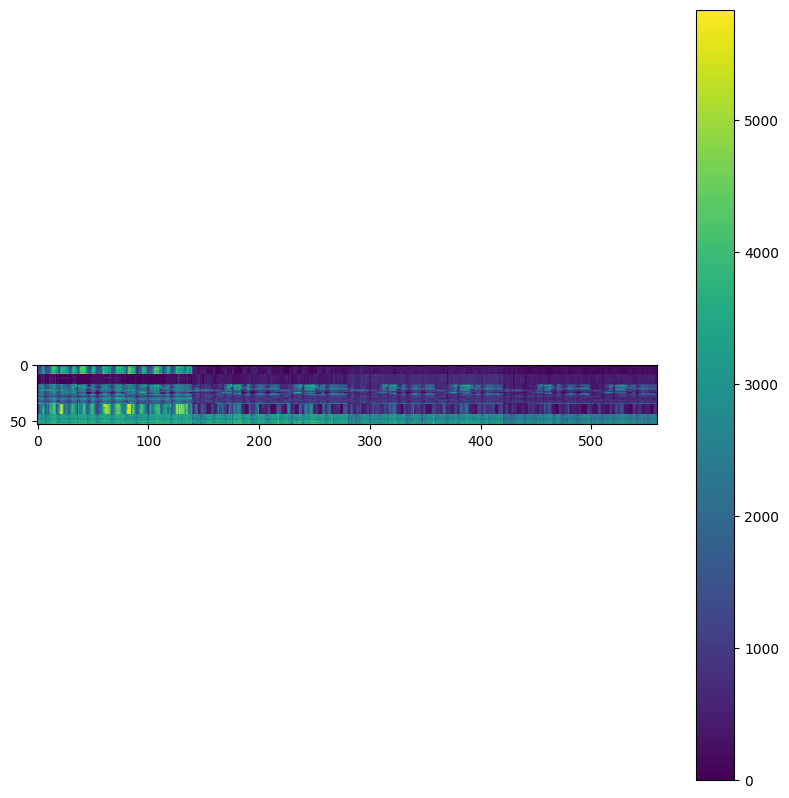

In [30]:
#Looking for a pixels
plt.figure(figsize=(10,10))
plt.imshow(TS_after_aggr)
plt.colorbar()
plt.show()

## Clustering

,accuracy,f1_score
0,0.925926,0.924779


,calinski_harabasz_score
0,94.328659


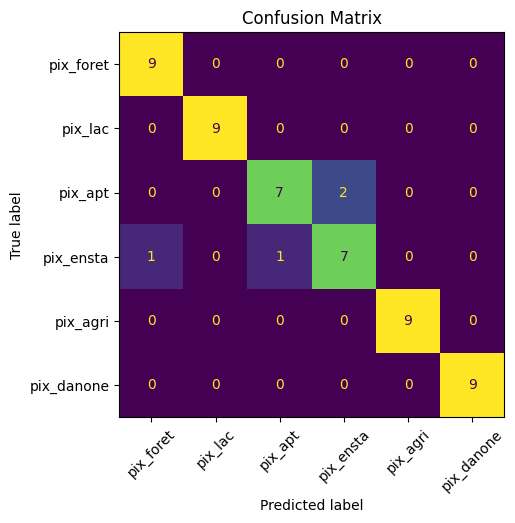

In [71]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

yhat_km = KMeans(n_clusters=6, random_state=0, n_init="auto").fit_predict(TS_after_aggr)
eval_concat_km = evaluator_de_experiences(yhat_km, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_km.confusion_matrix()
display(eval_concat_km.metrics_classif())
display(eval_concat_km.metrics_clustering())

,accuracy,f1_score
0,0.759259,0.715822


,calinski_harabasz_score
0,29.452598


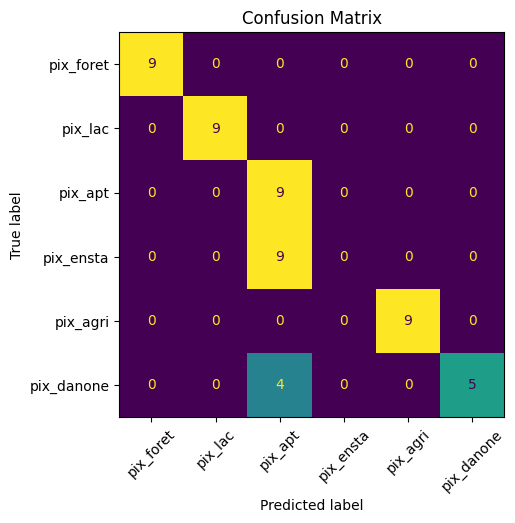

In [72]:
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering

#DBSCAN - euclidien
yhat_dbs = DBSCAN(eps=5000 ,min_samples=3, metric='euclidean').fit_predict(TS_after_aggr)
eval_concat_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_dbs.confusion_matrix()
display(eval_concat_dbs.metrics_classif())
display(eval_concat_dbs.metrics_clustering())


,accuracy,f1_score
0,0.925926,0.925


,calinski_harabasz_score
0,90.140968


(6,)


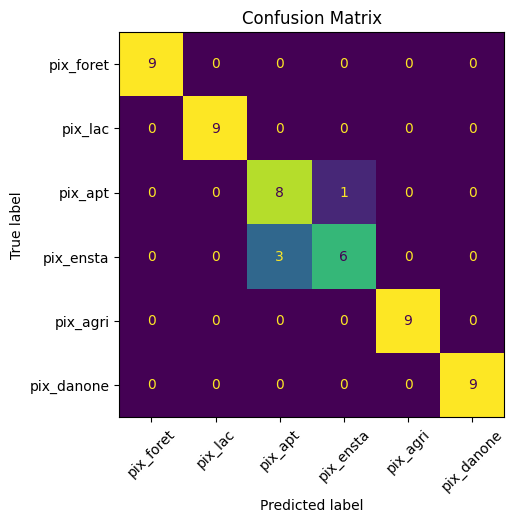

In [73]:
yhat_dbs = DBSCAN(eps=10000 ,min_samples=3, metric='euclidean').fit_predict(TS_after_aggr)
eval_concat_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_dbs.confusion_matrix()
display(eval_concat_dbs.metrics_classif())
display(eval_concat_dbs.metrics_clustering())
print(np.unique(yhat_dbs).shape)

26500
26600
26700
26800
26900
27000
27100
27200
27300
27400
27500
27600
27700
27800
27900
28000
28100
28200
28300
28400
28500
28600
28700
28800
28900
29000
29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
30100
30200
30300
30400
30500
30600
30700
30800
30900
31000
31100
31200
31300
31400
31500
31600
31700
31800
31900
32000
32100
32200
32300
32400
32500
32600
32700
32800
32900
33000
33100
33200
33300
33400
33500
33600
33700
33800
33900
34000
34100
34200
34300
34400
34500
34600
34700
34800
34900
35000
35100
35200
35300
35400
35500
35600
35700
35800
35900
36000
36100
36200
36300
36400
36500
36600
36700
36800
36900
37000
37100
37200
37300
37400
37500
37600
37700
37800
37900
38000
38100
38200
38300
38400
38500
38600
38700
38800
38900
39000
39100
39200
39300
39400
39500
39600
39700
39800
39900
40000
40100
40200
40300
40400
40500
40600
40700
40800
40900
41000
41100
41200
41300
41400
41500
41600
41700
41800
41900
42000
42100
42200
42300
42400
42500
42600
42700
42800
42900
43000
4310

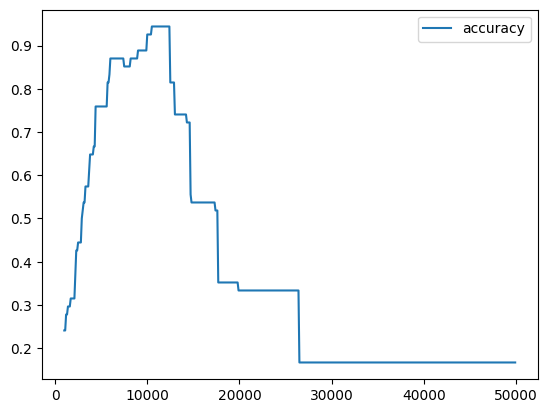

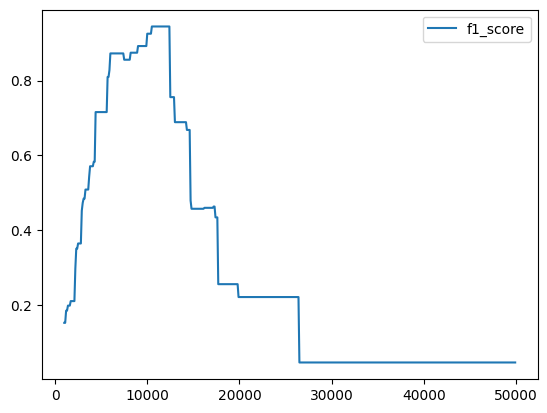

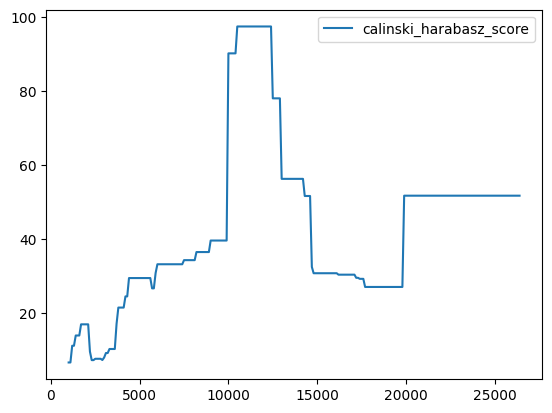

In [61]:
x = np.arange(1000, 50000, 100)
y_a = []
y_f = []
y_chi = []

xi = []

for i in x:
    yhat_dbs = DBSCAN(eps=i ,min_samples=3, metric='euclidean').fit_predict(TS_after_aggr)
    eval_concat_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_aggr)

    y_a.append(eval_concat_dbs.metrics_classif()['accuracy'][0])
    y_f.append(eval_concat_dbs.metrics_classif()['f1_score'][0])
    try:
        y_chi.append(eval_concat_dbs.metrics_clustering()['calinski_harabasz_score'][0])
        xi.append(i)
    except ValueError:
        print(i)

plt.plot(x, y_a, label="accuracy")
plt.legend()
plt.show()
plt.plot(x, y_f, label="f1_score")
plt.legend()
plt.show()
plt.plot(xi, y_chi, label="calinski_harabasz_score")
plt.legend()
plt.show()

,accuracy,f1_score
0,0.759259,0.776719


,calinski_harabasz_score
0,12.725443


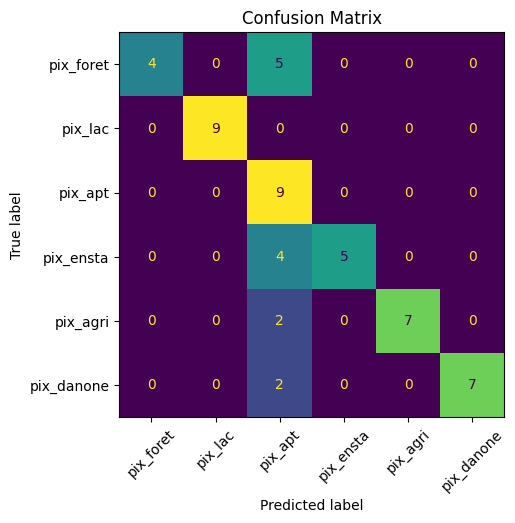

In [74]:
#OPTICS - euclidien
yhat_pts = OPTICS(min_samples=2, metric='euclidean').fit_predict(TS_after_aggr)
eval_concat_pts = evaluator_de_experiences(yhat_pts, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_pts.confusion_matrix()
display(eval_concat_pts.metrics_classif())
display(eval_concat_pts.metrics_clustering())



,accuracy,f1_score
0,0.87037,0.866667


,calinski_harabasz_score
0,98.192554


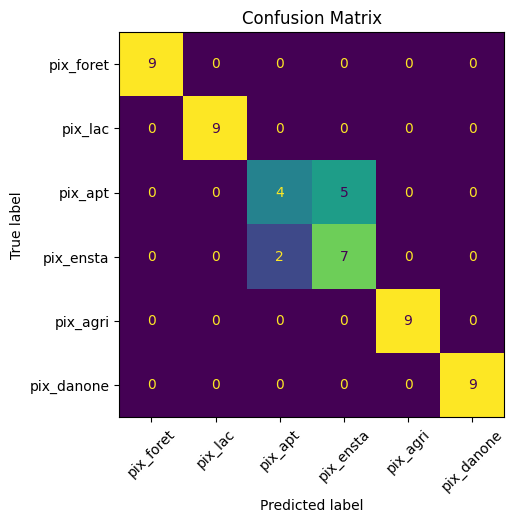

In [75]:
#CAH - euclidien
yhat_cah = AgglomerativeClustering(n_clusters=6, metric='euclidean').fit_predict(TS_after_aggr)
eval_concat_cah = evaluator_de_experiences(yhat_cah, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_cah.confusion_matrix()
display(eval_concat_cah.metrics_classif())
display(eval_concat_cah.metrics_clustering())

In [64]:
from scipy import spatial
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

def matrice_dtw(X, distance):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]= dtw.fastdtw(X[i],X[j],dist=distance)[0]
  return R

#mesure de similarité dtw entre deux séries temporelles. x = un pixel sur un intervalle de temps
def dtw_euclidien(x, x_prime):
  R=np.zeros((len(x),len(x_prime)))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = spatial.distance.euclidean(x[i], x_prime[j]) ** 2
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1] ** (1/2)

#pour tester avec le cosin
def dtw_cosine(x, x_prime):
  R=np.zeros((x.shape[0],x_prime.shape[0]))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = spatial.distance.cosine(x[i], x_prime[j])
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1]


#pour faire une matrice de similarité : donne la similarité entre toutes les séries temporelles. la matrice X
def matrice_dtw_euclidien(X):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]=dtw_euclidien(X[i],X[j])
  return R 


#pour tester avec le cosin
def matrice_dtw_cosine(X):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]=dtw_cosine(X[i],X[j])
  return R 


In [39]:
mat = TS_after_aggr.reshape((len(pixels_de_interet), len(images_list_original)*nband, 1))


In [40]:
matrice_dtw(mat, distance=euclidean)

array([[      0.,   57955.,   41460., ..., 1191221.,  881210., 1198193.],
       [  57955.,       0.,   33661., ..., 1043857.,  865064., 1053865.],
       [  41460.,   33661.,       0., ..., 1187711.,  925700., 1200617.],
       ...,
       [1191221., 1043857., 1187711., ...,       0.,  171354.,  117086.],
       [ 881210.,  865064.,  925700., ...,  171354.,       0.,  202660.],
       [1198193., 1053865., 1200617., ...,  117086.,  202660.,       0.]])

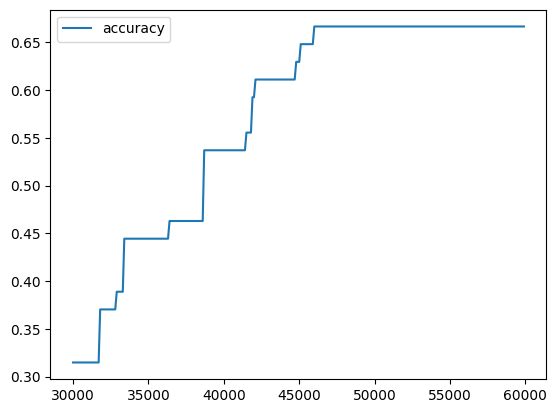

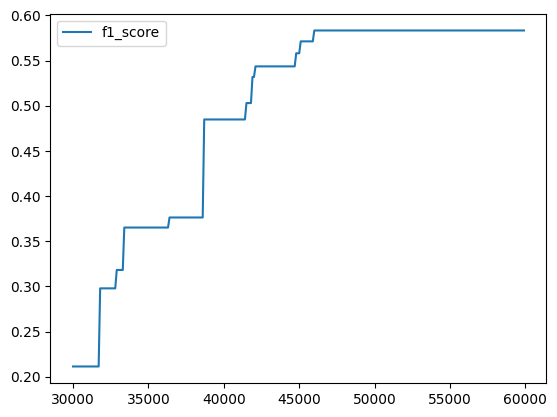

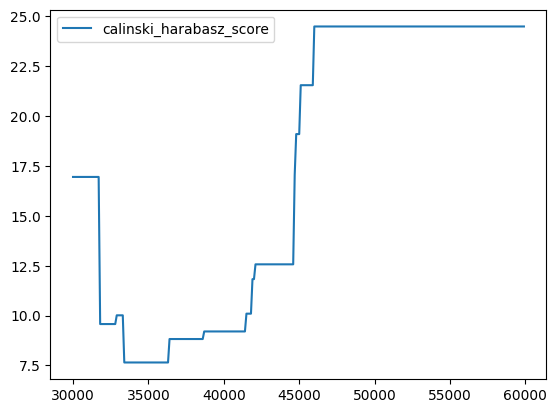

In [41]:
x = np.arange(30000, 60000, 100)
y_a = []
y_f = []
y_chi = []

xi = []

mat_dtw_aggr = matrice_dtw(mat, distance=euclidean)

for i in x:
    yhat_dbs = DBSCAN(eps=i ,min_samples=3, metric='precomputed').fit_predict(mat_dtw_aggr)
    eval_concat_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_aggr)

    y_a.append(eval_concat_dbs.metrics_classif()['accuracy'][0])
    y_f.append(eval_concat_dbs.metrics_classif()['f1_score'][0])
    try:
        y_chi.append(eval_concat_dbs.metrics_clustering()['calinski_harabasz_score'][0])
        xi.append(i)
    except ValueError:
        print(i)

plt.plot(x, y_a, label="accuracy")
plt.legend()
plt.show()
plt.plot(x, y_f, label="f1_score")
plt.legend()
plt.show()
plt.plot(xi, y_chi, label="calinski_harabasz_score")
plt.legend()
plt.show()

,accuracy,f1_score
0,0.537037,0.484832


,calinski_harabasz_score
0,9.205217


(5,)


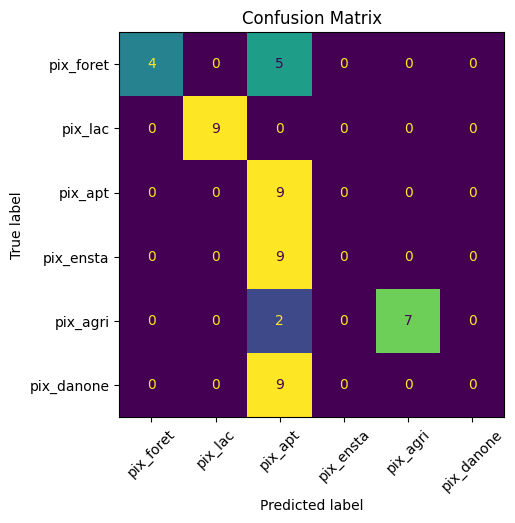

In [76]:
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering

# #DBSCAN - euclidien

yhat_dbs = DBSCAN(eps=40000 ,min_samples=3, metric='precomputed').fit_predict(mat_dtw_aggr)
eval_concat_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_dbs.confusion_matrix()
display(eval_concat_dbs.metrics_classif())
display(eval_concat_dbs.metrics_clustering())
print(np.unique(yhat_dbs).shape)


,accuracy,f1_score
0,0.833333,0.839402


,calinski_harabasz_score
0,17.461586


(12,)


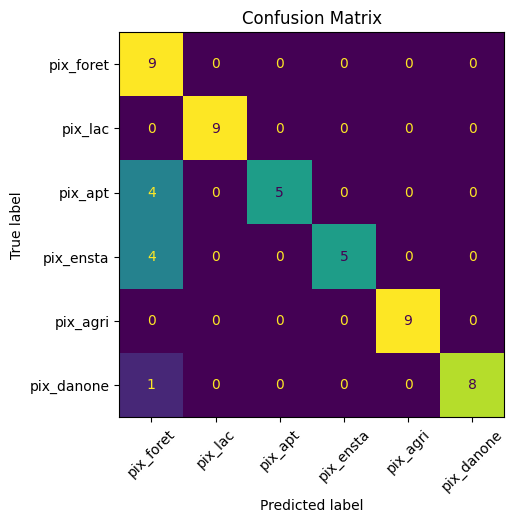

In [77]:
yhat_optics = OPTICS(min_samples=2, metric='precomputed').fit_predict(mat_dtw_aggr)
eval_concat_optics = evaluator_de_experiences(yhat_optics, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_optics.confusion_matrix()
display(eval_concat_optics.metrics_classif())
display(eval_concat_optics.metrics_clustering())
print(np.unique(yhat_optics).shape)

,accuracy,f1_score
0,0.907407,0.907121


,calinski_harabasz_score
0,98.732813


(6,)


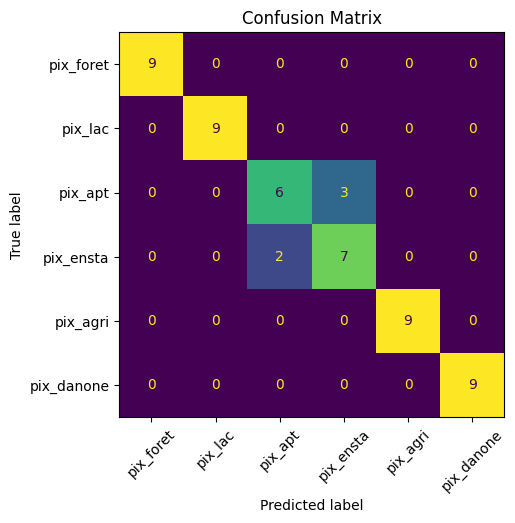

In [67]:
yhat_cah = AgglomerativeClustering(n_clusters=6, metric='precomputed', linkage='complete').fit_predict(mat_dtw_aggr)
eval_concat_cah = evaluator_de_experiences(yhat_cah, pixels_de_interet, dic_de_pixels, TS_after_aggr)
eval_concat_cah.confusion_matrix()
display(eval_concat_cah.metrics_classif())
display(eval_concat_cah.metrics_clustering())
print(np.unique(yhat_cah).shape)

In [52]:
nband = 4
images_list_values = np.zeros((len(pixels_de_interet),len(images_list_original), nband))
for image in images_list_original:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)            
        band3 = ds.read(3)
        band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        images_list_values[j,images_list_original.index(image),0] = band1[pixel[0], pixel[1]]
        images_list_values[j,images_list_original.index(image),1] = band2[pixel[0], pixel[1]]
        images_list_values[j,images_list_original.index(image),2] = band3[pixel[0], pixel[1]]
        images_list_values[j,images_list_original.index(image),3] = band4[pixel[0], pixel[1]]

In [55]:
TS_multi = images_list_values
TS_multi.shape

(54, 140, 4)

In [56]:
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering

# #DBSCAN - euclidien

yhat_dbs = DBSCAN(eps=40000 ,min_samples=3, metric='cosine').fit_predict(TS_multi)
eval_multi_dbs = evaluator_de_experiences(yhat_dbs, pixels_de_interet, dic_de_pixels, TS_multi)
eval_multi_dbs.confusion_matrix()
display(eval_multi_dbs.metrics_classif())
display(eval_multi_dbs.metrics_clustering())
print(np.unique(yhat_dbs).shape)

ValueError: Found array with dim 3. DBSCAN expected <= 2.

,accuracy,f1_score
0,0.814815,0.755735


,calinski_harabasz_score
0,108.988146


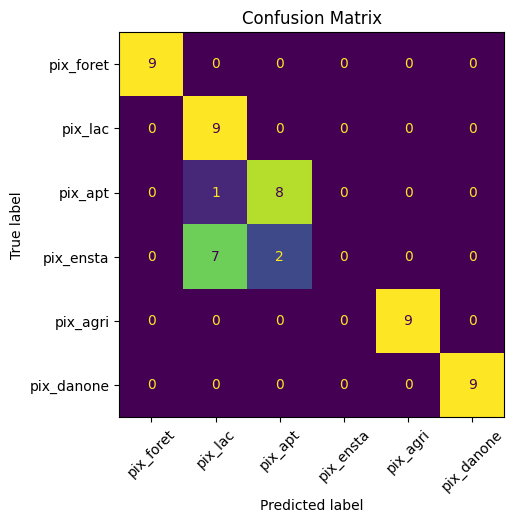

In [78]:
nband = 4
TS_green = np.zeros((len(pixels_de_interet),len(images_list_original)))
for image in images_list_original:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        # band1 = ds.read(1)
        # band2 = ds.read(2)            
        band3 = ds.read(3)
        # band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        # TS_green[j,images_list_original.index(image),0] = band1[pixel[0], pixel[1]]
        # TS_green[j,images_list_original.index(image),1] = band2[pixel[0], pixel[1]]
        TS_green[j,images_list_original.index(image)] = band3[pixel[0], pixel[1]]
        # TS_green[j,images_list_original.index(image),3] = band4[pixel[0], pixel[1]]

yhat_km = KMeans(n_clusters=6, random_state=0, n_init="auto").fit_predict(TS_green)
eval_green_km = evaluator_de_experiences(yhat_km, pixels_de_interet, dic_de_pixels, TS_green)
eval_green_km.confusion_matrix()
display(eval_green_km.metrics_classif())
display(eval_green_km.metrics_clustering())

In [85]:
for i,x in (zip(images_list_original,range(len(images_list_original)))):
    print(i,x)

crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif 0
crop_SENTINEL2A_20160125-111611-703_L2A_T31UDQ_D_V1-1.tif 1
crop_SENTINEL2A_20160312-105037-460_L2A_T31UDQ_D_V1-1.tif 2
crop_SENTINEL2A_20160315-110157-618_L2A_T31UDQ_D_V1-1.tif 3
crop_SENTINEL2A_20160504-105917-634_L2A_T31UDQ_D_V1-1.tif 4
crop_SENTINEL2A_20160822-110529-373_L2A_T31UDQ_D_V1-1.tif 5
crop_SENTINEL2A_20160921-110634-627_L2A_T31UDQ_D_V1-1.tif 6
crop_SENTINEL2A_20161227-105527-361_L2A_T31UDQ_D_V1-4.tif 7
crop_SENTINEL2A_20170119-110533-087_L2A_T31UDQ_D_V1-4.tif 8
crop_SENTINEL2A_20170126-105612-238_L2A_T31UDQ_D_V1-4.tif 9
crop_SENTINEL2A_20170215-105607-471_L2A_T31UDQ_D_V1-4.tif 10
crop_SENTINEL2A_20170330-110334-389_L2A_T31UDQ_D_V1-4.tif 11
crop_SENTINEL2A_20170409-110529-978_L2A_T31UDQ_D_V1-4.tif 12
crop_SENTINEL2A_20170509-110556-093_L2A_T31UDQ_D_V1-4.tif 13
crop_SENTINEL2A_20170526-105518-082_L2A_T31UDQ_D_V1-4.tif 14
crop_SENTINEL2A_20170615-105505-255_L2A_T31UDQ_D_V1-4.tif 15
crop_SENTINEL2A_20170618-110415-68